In [1]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import pandas as pd
from scipy.spatial import cKDTree

In [2]:
def lon_lat_to_cartesian(lon, lat, R=6371000):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return x, y, z

In [3]:
def create_indexes_and_distances(model_lon, model_lat, lons, lats, k=1, workers=2):
    """
    Creates KDTree object and query it for indexes of points in FESOM mesh that are close to the
    points of the target grid. Also return distances of the original points to target points.
    Parameters
    ----------
    mesh : fesom_mesh object
        pyfesom mesh representation
    lons/lats : array
        2d arrays with target grid values.
    k : int
        k-th nearest neighbors to return.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors.
    inds : ndarray of ints
        The locations of the neighbors in data.
    """
    xs, ys, zs = lon_lat_to_cartesian(model_lon, model_lat)
    xt, yt, zt = lon_lat_to_cartesian(lons.flatten(), lats.flatten())

    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k=k, workers=workers)

    return distances, inds

In [4]:
catalog_file = "/home/k/k203123/NextGEMS_Cycle2.git/experiments/ngc2009/scripts/ngc2009.json"

In [5]:
cat = intake.open_esm_datastore(catalog_file)
cat

,unique
variable_id,155
project,1
institution_id,1
source_id,1
experiment_id,1
simulation_id,1
realm,2
frequency,7
time_reduction,2
grid_label,1


In [6]:
def get_from_cat(catalog, columns):
    if type (columns) == type (""):
        columns = [columns]
    return catalog.df[columns].drop_duplicates().sort_values(columns)

In [7]:
pd.set_option("max_colwidth", None)
overview = get_from_cat(cat, ["experiment_id", "source_id", "realm", "frequency", "variable_id"])
overview

,experiment_id,source_id,realm,frequency,variable_id
4945,nextgems_cycle2,ICON-ESM,atm,1day,"(clt, evspsbl, tas, ts, rldscs, rlutcs, rsdscs, rsuscs, rsutcs)"
7789,nextgems_cycle2,ICON-ESM,atm,1day,"(psl, clt, evspsbl, tas, ts, rldscs, rlutcs, rsdscs, rsuscs, rsutcs)"
49,nextgems_cycle2,ICON-ESM,atm,2hour,"(phalf,)"
145,nextgems_cycle2,ICON-ESM,atm,30minute,"(hydro_canopy_cond_limited_box, hydro_w_snow_box, hydro_snow_soil_dens_box)"
129,nextgems_cycle2,ICON-ESM,atm,30minute,"(hydro_discharge_ocean_box, hydro_drainage_box, hydro_runoff_box, hydro_transpiration_box, sse_grnd_hflx_old_box)"
33,nextgems_cycle2,ICON-ESM,atm,30minute,"(psl, ps, sit, sic, tas, ts, uas, vas, cfh_lnd)"
17,nextgems_cycle2,ICON-ESM,atm,30minute,"(sfcwind, clivi, cllvi, cptgzvi, hfls, hfss, prlr, pr, prw, qgvi, qrvi, qsvi, rlds, rlus, rlut, rsds, rsdt, rsus, rsut, tauu, tauv, rpds_dir, rpds_dif, rvds_dif, rnds_dif)"
97,nextgems_cycle2,ICON-ESM,atm,6hour,"(clw, cli, pfull)"
161,nextgems_cycle2,ICON-ESM,atm,6hour,"(hydro_w_soil_sl_box, hydro_w_ice_sl_box, sse_t_soil_sl_box)"
81,nextgems_cycle2,ICON-ESM,atm,6hour,"(ta, hus, rho)"


In [8]:
cat.search(realm="oce", frequency='1hour', variable_id='conc')

,unique
variable_id,14
project,1
institution_id,1
source_id,1
experiment_id,1
simulation_id,1
realm,1
frequency,1
time_reduction,1
grid_label,1


In [9]:
final_query = cat.search(realm="oce", frequency='1hour', variable_id='conc')

In [10]:
dataset_dict = final_query.to_dataset_dict(
    cdf_kwargs={
        "chunks": dict(
            time=1,
            # height=1,
        )
    }
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.simulation_id.realm.frequency.time_reduction.grid_label.level_type'


In [11]:
dataset_dict

{'nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2009.oce.1hour.inst.gn.ml': <xarray.Dataset>
 Dimensions:  (time: 18504, lev: 1, ncells: 14886338)
 Coordinates:
   * lev      (lev) float64 0.0
   * time     (time) datetime64[ns] 2020-01-20T01:00:00 ... 2022-03-01
 Dimensions without coordinates: ncells
 Data variables:
     conc     (time, lev, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
 Attributes: (12/13)
     history:                 ./icon at 20220512 152214\n./icon at 20220512 19...
     Conventions:             CF-1.6
     CDI:                     Climate Data Interface version 1.8.3rc (http://m...
     uuidOfHGrid:             375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b
     references:              see MPIM/DWD publications
     intake_esm_varname:      ['conc']
     ...                      ...
     title:                   ICON simulation
     grid_file_uri:           http://icon-downloads.mpimet.mpg.de/grids/public...
     source:                  git@gitl

In [12]:
keys = list(dataset_dict.keys())
keys

['nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2009.oce.1hour.inst.gn.ml']

In [13]:
data = dataset_dict[keys[0]]
data

<xarray.Dataset>
Dimensions:  (time: 18504, lev: 1, ncells: 14886338)
Coordinates:
  * lev      (lev) float64 0.0
  * time     (time) datetime64[ns] 2020-01-20T01:00:00 ... 2022-03-01
Dimensions without coordinates: ncells
Data variables:
    conc     (time, lev, ncells) float32 dask.array<chunksize=(1, 1, 14886338), meta=np.ndarray>
Attributes: (12/13)
    history:                 ./icon at 20220512 152214\n./icon at 20220512 19...
    Conventions:             CF-1.6
    CDI:                     Climate Data Interface version 1.8.3rc (http://m...
    uuidOfHGrid:             375cb0cc-637e-11e8-9d6f-8f41a9b9ff4b
    references:              see MPIM/DWD publications
    intake_esm_varname:      ['conc']
    ...                      ...
    title:                   ICON simulation
    grid_file_uri:           http://icon-downloads.mpimet.mpg.de/grids/public...
    source:                  git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69...
    number_of_grid_used:     16
    comment:                 Sapphire Dyamond (k203123) on l10742 (Linux 4.18...
    intake_esm_dataset_key:  nextGEMS.MPI-M.ICON-ESM.nextgems_cycle2.ngc2009....

In [14]:
data_sample = data.conc[0,0,:]

In [15]:
data_sample

<xarray.DataArray 'conc' (ncells: 14886338)>
dask.array<getitem, shape=(14886338,), dtype=float32, chunksize=(14886338,), chunktype=numpy.ndarray>
Coordinates:
    lev      float64 0.0
    time     datetime64[ns] 2020-01-20T01:00:00
Dimensions without coordinates: ncells
Attributes:
    standard_name:                conc
    long_name:                    ice concentration in each ice class
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [16]:
data_sample.shape

(14886338,)

In [17]:
data_sample.values

array([0.97209835, 0.77431667, 0.8090583 , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [18]:
grid_path = "/pool/data/ICON/grids/public/mpim/0016/icon_grid_0016_R02B09_O.nc"
grid = xr.open_dataset(grid_path)

Model Grid

In [19]:
model_lon_icon = grid.clon.values*180./np.pi
model_lat_icon = grid.clat.values*180./np.pi

In [20]:
model_lon_icon.shape

(14886338,)

Target grid

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

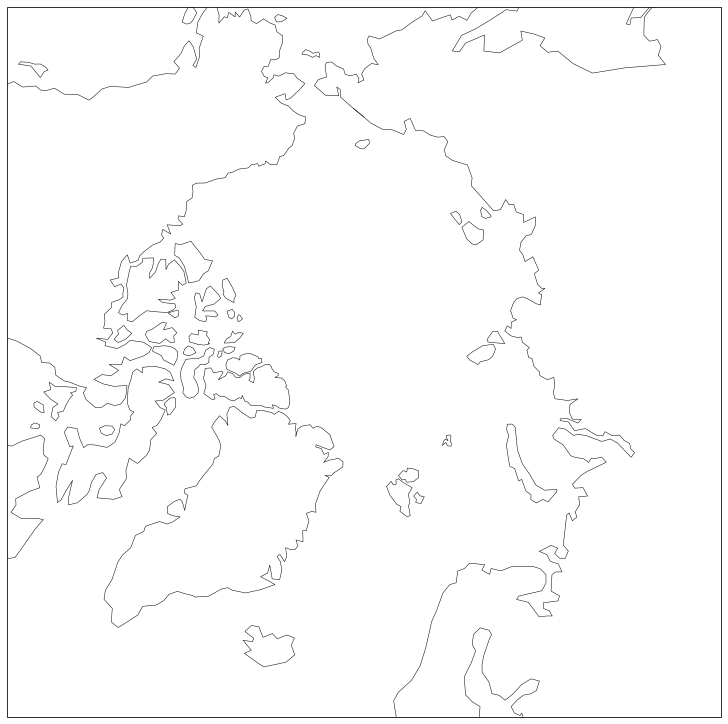

In [22]:
left = -180
right = 180
bottom = 60
top = 90
fig, ax = plt.subplots(
            1,
            1,
            subplot_kw=dict(projection=ccrs.NorthPolarStereo()),
            constrained_layout=True,
            figsize=(10,10),
        )
sstep = 10
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
ax.coastlines(resolution = '110m',lw=0.5)

In [23]:
xmin, xmax = ax.get_xbound()
ymin, ymax = ax.get_ybound()
nx = int((xmax-xmin)/2000)+1; ny = int((ymax-ymin)/2000)+1
x = np.linspace(xmin,xmax,nx)
y = np.linspace(ymin,ymax,ny)
x,y = np.meshgrid(x,y)

In [24]:
x.shape

(3380, 3400)

In [25]:
npstere = ccrs.PlateCarree()
transformed2 =  npstere.transform_points(ccrs.NorthPolarStereo(), x, y)
# transformed2 =  npstere.transform_points(ccrs.PlateCarree(), x, y)

In [26]:
x2 = transformed2[:,:,0]#.ravel()
y2 = transformed2[:,:,1]#.ravel()

In [27]:
import cmocean.cm as cmo

In [28]:
distances, inds = create_indexes_and_distances(model_lon_icon, model_lat_icon, x2, y2, k=1, workers=10)

In [40]:
ttime = 5000
data_sample = data.conc[ttime,0,:]
print(data_sample.time)
radius_of_influence=5000
data_interpolated = data_sample.values[inds]
data_interpolated[distances >= radius_of_influence] = np.nan
data_interpolated = data_interpolated.reshape(x2.shape)
data_interpolated = np.ma.masked_invalid(data_interpolated)

<xarray.DataArray 'time' ()>
array('2020-08-15T09:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    lev      float64 0.0
    time     datetime64[ns] 2020-08-15T09:00:00
Attributes:
    standard_name:  time
    axis:           T


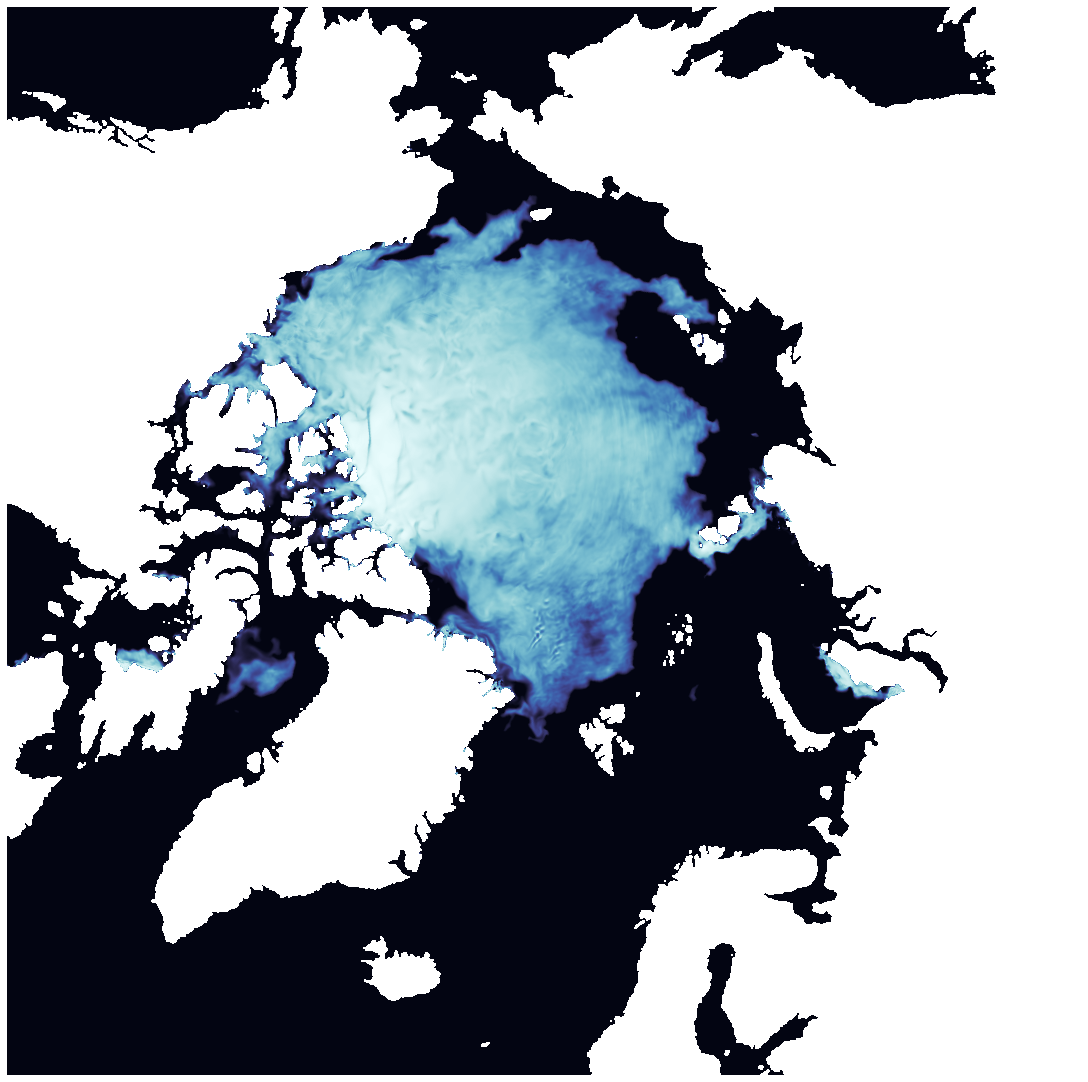

In [42]:
fig, ax = plt.subplots(
            1,
            1,
            constrained_layout=True,
            figsize=(15,15),
        )
pp = ax.imshow(np.flipud(data_interpolated), cmap=cmo.ice, vmin=0, vmax=1)
ax.axis('off');